# Minimal Implementation for Dynamics of Specialization

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from functools import partial
import copy

In [2]:
%load_ext autoreload
%autoreload 2


## Data

### Generate

In [3]:
from dynspec.datasets import get_datasets
from dynspec.data_process import process_data

In [4]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 512

In [5]:
n_agents = 2
n_classes_per_digit = 10
n_classes = n_classes_per_digit * n_agents
nb_steps = 5

data_config = {
    # ------ Change if needed------
    "batch_size": 512,
    "input_size": 28,
    "use_cuda": use_cuda,
    "data_type": "double_digits",
    "n_digits": n_agents,
    "n_classes": n_classes,
    "n_classes_per_digit": n_classes_per_digit,
    "nb_steps": nb_steps,
    "common_input": True,
    "cov_ratio": 1,
    "noise_ratio": 0.5,
    "random_start": False,
    # ------ Leave as is -------
    "data_size": None,
    "fix_asym": True,
    "permute_dataset": False,
    "split_classes": True,
    "seed": np.random.randint(100),
    # --------------------------
}

In [6]:
all_data = get_datasets("../data/", data_config)
datasets, loaders = all_data[data_config["data_type"]]

### Plot

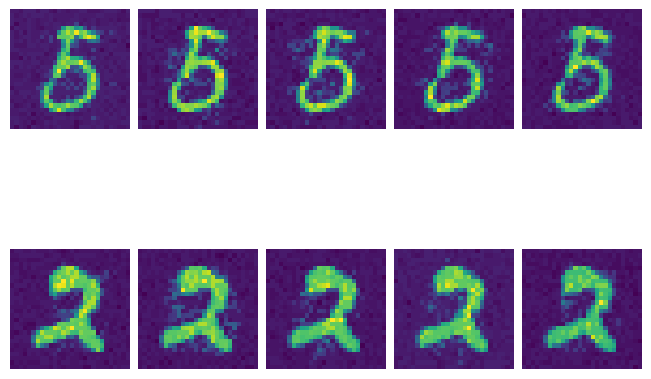

In [7]:
data, target = next(iter(loaders[0]))
temporal_data, _ = process_data(data, data_config)
if data_config["common_input"]:
    temporal_data = torch.stack(
        temporal_data.split(temporal_data.shape[-1] // n_agents, -1), 1
    )

fig, axs = plt.subplots(n_agents, temporal_data.shape[0], constrained_layout=True)
for t_data, t_axs in zip(temporal_data, axs.T):
    for d, ax in zip(t_data, t_axs):
        ax.imshow(d[0].cpu().numpy().reshape(28, 28))
        ax.axis("off")

## Init Models

In [8]:
from dynspec.models import masked_GRU, masked_RNN, Community


In [9]:
task = ["parity-digits", "inv-parity-digits"]
# task = "parity-digits"

n_hidden = 25

agents_config = {
    "n_agents": 2,
    "hidden_size": n_hidden,
    "n_layers": 1,
    "dropout": 0.0,
    "cell_type": str(masked_RNN),
}

n_conns = 2
connections_config = {"sparsity": n_conns / agents_config["hidden_size"] ** 2}

n_outs = {
    "none": [10, 10],
    "parity-digits": 10,
    "inv-parity-digits": 10,
    "parity-digits-both": [10, 10],
    "parity-digits-sum": 2,
    "sum": 20,
    "bitxor": 16,
    "bitxor-last-1": 2,
    "1": 10,
    "0": 10,
    "inv": 10,
}

input_config = {"input_size": data_config["input_size"] ** 2, "common_input": False}
optim_config = {"lr": 1e-3, "weight_decay": 1e-4}

readout_config = {
    "output_size": n_outs[task]
    if not isinstance(task, list)
    else [n_outs[t] for t in task],
    "common_readout": False,
}

decision = ["last", "max"]

training_config = {
    "n_epochs": 30,
    "task": task,
}

config = {
    "agents": agents_config,
    "connections": connections_config,
    "input": input_config,
    "readout": readout_config,
    "data": data_config,
    "decision": decision,
    "training": training_config,
    "optim": optim_config,
}

In [10]:
def find_and_change(config, param_name, param_value):
    for key, value in config.items():
        if type(value) is dict:
            find_and_change(value, param_name, param_value)
        else:
            if key == param_name:
                config[key] = param_value

    return config


def copy_and_change_config(config, varying_params):
    config = copy.deepcopy(config)
    for n, v in varying_params.items():
        find_and_change(config, n, v)

    return config


def get_all_v_params(varying_params, excluded_params={}):
    return [
        {
            k: p
            for k, p in zip(varying_params.keys(), params)
            if k not in excluded_params
        }
        for params in product(*varying_params.values())
    ]

In [11]:
n_conns = np.geomspace(1, n_hidden**2, 4, dtype=int)
# n_conns = np.array([1, n_hidden**2]) / n_hidden**2
n_tests = 1
varying_params = {"sparsity": np.unique(np.round(n_conns/ n_hidden**2, 4))}

all_varying_params = get_all_v_params(varying_params)
configs = [
    [copy_and_change_config(config, p) for p in all_varying_params]
    for _ in range(n_tests)
]
all_configs = [c for l in configs for c in l]
len(all_configs), n_conns


(4, array([  1,   8,  73, 625]))

In [12]:
models = [Community(config).to(device) for config in all_configs]

optimizers = [
    torch.optim.AdamW(model.parameters(), **config["optim"])
    for model, config in zip(models, all_configs)
]


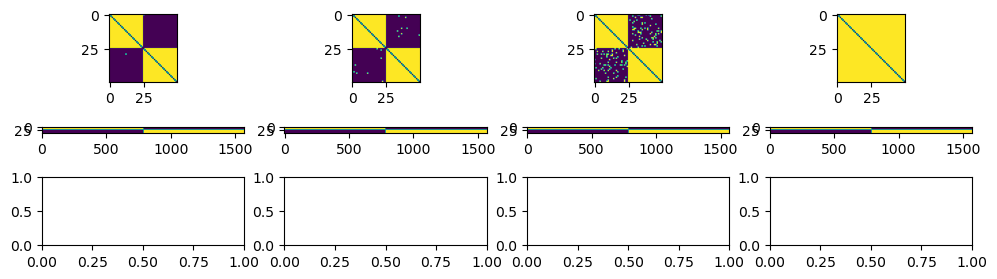

In [13]:

fig, axs = plt.subplots(3, len(configs[0]), figsize=(len(configs[0]) * 3, 3))
if len(all_configs) == 1 : 
    axs = np.array([axs]).T
[
    ax.imshow((model.masks["comms_mask"] + model.masks["rec_mask"]).cpu().numpy())
    for model, ax in zip(models, axs[0])
]
[
    ax.imshow((model.masks["input_mask"]).cpu().numpy())
    for model, ax in zip(models, axs[1])
]
# [ax.imshow((model.masks['output_mask']).cpu().numpy()) for model, ax in zip(models, axs[2])];

## Training

In [14]:
from dynspec.training import train_community, get_acc, get_loss
from dynspec.decision import get_decision
from dynspec.tasks import get_task_target


In [15]:
# data, target = next(iter(loaders[0]))
if False:
    means = []
    base_accs = []
    for data, target in loaders[1]:
        data, _ = process_data(data, data_config)
        data, target = data.to(device), target.to(device)
        out, _ = models[0](data)
        t_target = get_task_target(target, task, data_config["n_classes_per_digit"])

        means.append(
            [(t_t == target.T).float().mean(1).cpu().data.numpy() for t_t in t_target]
        )
        output, _ = get_decision(out, *decision)
        base_accs.append(get_acc(output, t_target, use_both=decision[1] == "both")[0])

In [26]:
parallel = False

import multiprocess as mp
import multiprocess.context as ctx

ctx._force_start_method("spawn")


def train(params):
    model, optimizer, config, use_tqdm, loaders = params
    from dynspec.training import train_community
    import torch

    use_cuda = torch.cuda.is_available()

    return train_community(
        model,
        optimizer,
        config,
        loaders=loaders,
        stop_acc=0.95,
        device=torch.device("cuda" if use_cuda else "cpu"),
        show_all_acc=False,
        use_tqdm=use_tqdm,
    )


if parallel:
    try:
        pool = mp.Pool(processes=len(models))
        train_results = pool.map(
            train,
            zip(
                models,
                optimizers,
                all_configs,
                [i == len(all_configs) - 1 for i in range(len(all_configs))],
                [copy.deepcopy(loaders) for _ in all_configs],
            ),
        )
    finally:
        pool.close()
else:
    train_results = [
        train_community(
            model,
            optimizer,
            config,
            loaders,
            stop_acc=0.95,
            device=device,
            show_all_acc=True,
            n_epochs=int(15 + 30 * (1 - config["connections"]["sparsity"])),
        )
        for model, optimizer, config in zip(models, optimizers, all_configs)
    ]

Train Epoch::   0%|          | 0/45 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/45 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/42 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/16 [00:00<?, ?it/s]

0.0032

### Results

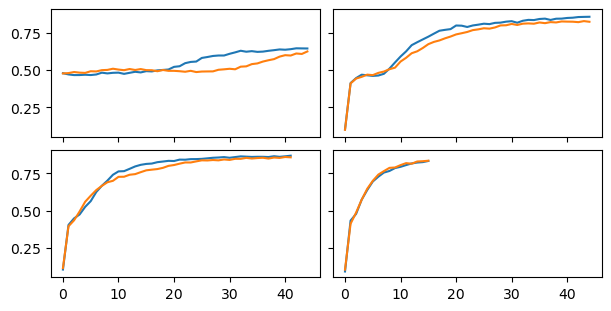

In [27]:
from math import sqrt, ceil

n1, n2 = int(sqrt(len(all_configs))), int(ceil(sqrt(len(all_configs))))

fig, axs = plt.subplots(
    n1,
    n2,
    figsize=(3 * n2, n1 * 1.5),
    constrained_layout=True,
    sharey=True,
    sharex=True,
)
if n1 == n2 == 1:
    axs = np.array([axs])

[
    ax.plot(t["test_accs"].reshape(t["test_accs"].shape[0], -1))
    for t, ax in zip(train_results, axs.flatten())
];

In [ ]:
raise StopIteration

### Analysis

In [ ]:
data, target = next(iter(loaders[1]))
data, _ = process_data(data, data_config)
data.shape
out, states = model(data.to(device))
out.shape, states.shape
t_target = get_task_target(target, task, data_config["n_classes_per_digit"])

In [ ]:
comms_sent = states[
    ...,
    (model.comms_mask.split(100, 0)[0] * (1 - model.state_mask.split(100, 0)[0]))
    .to(bool)
    .any(1),
][-1]
comms_received = states[
    ...,
    (model.comms_mask.split(100, 0)[0] * (1 - model.state_mask.split(100, 0)[0]))
    .to(bool)
    .any(0),
][-1]

In [ ]:
comms_sent.shape

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
try:
    axs[0]
except TypeError:
    axs = np.array([axs])
for comms, axs_c in zip([comms_sent, comms_received], axs):
    try:
        axs_c[0]
    except TypeError:
        axs_c = np.array([axs_c])
    for (i, j), ax in zip(product(range(2), repeat=2), axs_c.flatten()):
        try:
            ax.scatter(
                comms[:, 2 * i].cpu().data.numpy(),
                comms[:, 2 * i].cpu().data.numpy(),
                c=t_target,
            )
        except IndexError:
            ax.scatter(
                range(len(comms[:, i])), comms[:, i].cpu().data.numpy(), c=t_target
            )

## Metrics

In [28]:
from dynspec.plotting import set_style, filter_data


### Retraining

In [29]:
from dynspec.metrics import compute_retraining_metric

In [30]:
if False:
    try:
        pool = mp.Pool(processes=len(models))
        retrain_results = pool.starmap(
            compute_retraining_metric,
            zip(
                models,
                all_configs,
                [copy.deepcopy(loaders) for _ in all_configs],
                [device for _ in all_configs],
                [i == len(all_configs) - 1 for i in range(len(all_configs))]
            ),
        )
    finally:
        pool.close()

else:
    retrain_results = [
        compute_retraining_metric(model, config, loaders, device, use_tqdm=True)
        for model, config in zip(models, all_configs)
    ]

Train Epoch::   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/11 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/11 [00:00<?, ?it/s]

In [31]:
retraining_metrics, retraining_models, retraining_configs = [[r[i] for r in retrain_results] for i in range(3)]

In [32]:
if parallel:
    pool = mp.Pool(processes=len(models))
    retrain_results = pool.map(
        train,
        zip(
            retraining_models,
            retraining_optimizers,
            retraining_configs,
            [i == len(retraining_configs) - 1 for i in range(len(retraining_configs))],
            [copy.deepcopy(loaders) for _ in retraining_configs],
        ),
    )

else:
    retrain_results = [
        train_community(
            retraining_model,
            retraining_optimizer,
            retraining_config,
            loaders,
            stop_acc=0.95,
            device=device,
            show_all_acc=False,
        )
        for retraining_model, retraining_optimizer, retraining_config in zip(
            retraining_models, retraining_optimizers, retraining_configs
        )
    ]

NameError: name 'retraining_optimizers' is not defined

In [33]:
metric_norm = lambda m: np.clip(m - 0.1 / (1 - 0.1), 0, 1)
diff_metric = lambda metric: (metric[0] - metric[1]) / ((metric[0]) + (metric[1]))
global_diff_metric = (
    lambda metric: np.abs(diff_metric(metric[0]) - diff_metric(metric[1])) / 2
)

det = lambda M: np.abs(np.linalg.det(M))
diff_metric = lambda col: (col[0] - col[1]) / col.sum()
normed_det = lambda M: det(M) / M.sum(0).prod()

In [34]:
retrain_accs = [metric_norm(r["test_accs"][-1]) for r in retraining_metrics]
retrain_all_accs = [metric_norm(r["all_accs"][-1]) for r in retraining_metrics]


In [35]:
retrain_global_data = {k: [] for k in ["metric", "n_conns", "step"]}
for r_accs, conns in zip(retrain_accs, np.array([n_conns for _ in range(n_tests)]).flatten()):
    retrain_global_data["metric"].extend(global_diff_metric(r) for r in r_accs)
    retrain_global_data["n_conns"].extend([conns] * len(r_accs))
    retrain_global_data["step"].extend(range(len(r_accs)))


In [36]:
import seaborn as sns
import pandas as pd

<Axes: xlabel='step', ylabel='metric'>

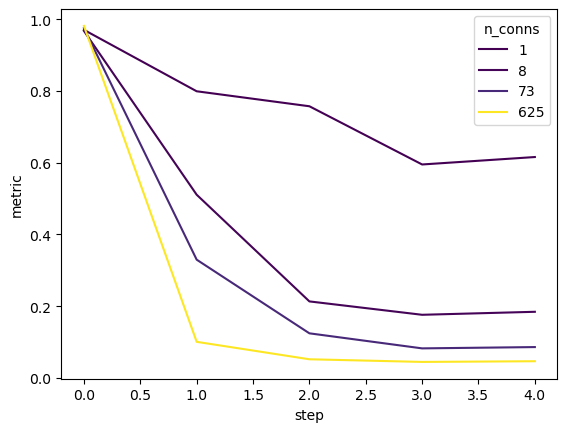

In [37]:
sns.lineplot(
    data=retrain_global_data, x="step", y="metric", hue="n_conns", palette="viridis"
)

In [38]:
retrain_ag_data = {k: [] for k in ["metric", "n_conns", "step", "ag"]}

for r_accs, conns in zip(retrain_accs, np.array([n_conns for _ in range(n_tests)]).flatten() ):
    for step, s_accs in enumerate(r_accs):
        for ag, ag_accs in enumerate(s_accs[:2]):
            retrain_ag_data["metric"].append(diff_metric(ag_accs))
            retrain_ag_data["n_conns"].append(conns)
            retrain_ag_data["step"].append(step)
            retrain_ag_data["ag"].append(ag)

retrain_ag_data = pd.DataFrame.from_dict(retrain_ag_data)


<Axes: xlabel='step', ylabel='metric'>

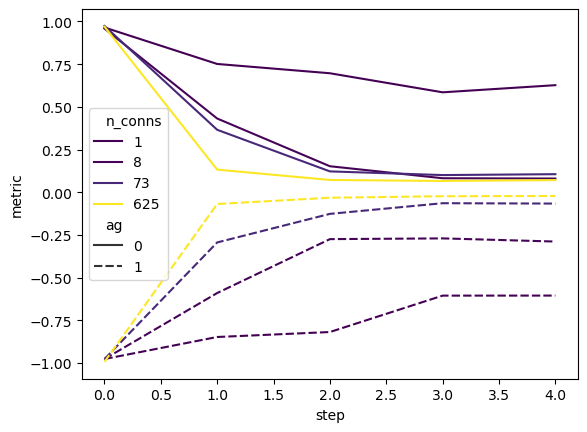

In [39]:
sns.lineplot(
    data=retrain_ag_data,
    x="step",
    y="metric",
    hue="n_conns",
    style="ag",
    palette="viridis",
)


### Random Timings

In [40]:
from tqdm.notebook import tqdm


In [41]:
all_outputs = []
all_start_times = []
all_targets = []

random_config = config.copy()
random_config["data"]["random_start"] = True

def reccursive_stack(input):
    try:
        return torch.stack(input)
    except TypeError:
        return torch.stack([reccursive_stack(i) for i in input])

for n, n_s in enumerate(tqdm(n_conns)) : 
    all_outputs.append([])
    all_start_times.append([])
    all_targets.append([])    

    for net, config in zip(retraining_models[n::len(n_conns)], all_configs[n::len(n_conns)]):

        all_outputs[-1].append([])
        all_start_times[-1].append([])
        all_targets[-1].append([])    

        for data, target in loaders[1]:
            data, start_times = process_data(data, random_config["data"])
            data, target = data.to(device), target.to(device)
            outputs, _ = net(data)
            outputs = reccursive_stack(outputs).transpose(0, 2).squeeze()
            all_outputs[-1][-1].append(outputs) # steps x agents x target
            all_start_times[-1][-1].append(start_times)
            all_targets[-1][-1].append(target)
        
        all_outputs[-1][-1] = torch.cat(all_outputs[-1][-1], -2)
        all_start_times[-1][-1] = torch.cat(all_start_times[-1][-1], -2)
        all_targets[-1][-1] = torch.cat(all_targets[-1][-1], -2)


  0%|          | 0/4 [00:00<?, ?it/s]

In [43]:
all_outputs, all_start_times, all_targets = [
    {
        n_s: reccursive_stack(r).squeeze()
        for n_s, r in zip(n_conns, all_r)
    }
    for all_r in [all_outputs, all_start_times, all_targets]
]

In [44]:
all_outputs[n_conns[0]].shape, all_targets[n_conns[0]].shape

# all_outputs = {n_s: o.transpose(1, 2) for n_s, o in all_outputs.items()}
# all_outputs[n_conns[0]].shape


(torch.Size([5, 3, 2, 7680, 10]), torch.Size([7680, 2]))

In [ ]:
get_acc(all_outputs[n_conns[0]], [[[t for t in all_targets[n_conns[0]].T]  for _ in range(n_agents+1)] for _ in range(nb_steps)])

(array([[[0.09895834, 0.10533854],
         [0.10520834, 0.09960938],
         [0.09947917, 0.10520834]],
 
        [[0.34244794, 0.09960938],
         [0.1061198 , 0.33450523],
         [0.32578126, 0.32838544]],
 
        [[0.5542969 , 0.277474  ],
         [0.28645834, 0.53476566],
         [0.53619796, 0.5279948 ]],
 
        [[0.761198  , 0.42070314],
         [0.48502606, 0.74218756],
         [0.7447917 , 0.7356771 ]],
 
        [[0.82968754, 0.5885417 ],
         [0.70312506, 0.7992188 ],
         [0.8246094 , 0.8014323 ]]], dtype=float32),
 array([[[[False,  True, False, ..., False, False,  True],
          [False, False, False, ..., False, False, False]],
 
         [[ True, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
 
         [[False,  True, False, ..., False, False,  True],
          [False, False, False, ..., False, False, False]]],
 
 
        [[[False,  True, False, ..., False, False,  True],
          [False, Fa

In [45]:
all_accs = {
    n_s: np.stack(
        [
            get_acc(o, [[[t for t in target.T] for _ in range(n_agents + 1)] for _ in range(nb_steps)])[1]
            for o, target in zip([all_outs], [all_ts])
        ]
    )
    for (n_s, all_outs), all_ts in zip(all_outputs.items(), all_targets.values())
}

all_accs[n_conns[0]].shape

(1, 5, 3, 2, 7680)

In [46]:
all_u_masks = {
    n_s: np.array([[(all_s == u).all(-1) for u in all_s.unique(dim=0)] for all_s in [all_start]])
    for n_s, all_start in all_start_times.items()
}
all_u_masks[n_conns[0]].shape

(1, 9, 7680)

In [47]:
all_accs[625].mean(-1).mean(0)

array([[[0.10286458, 0.10963542],
        [0.09322917, 0.09921875],
        [0.10208333, 0.10286458]],

       [[0.34479167, 0.10507812],
        [0.10755208, 0.34739583],
        [0.33684896, 0.334375  ]],

       [[0.56940104, 0.27760417],
        [0.29166667, 0.56575521],
        [0.553125  , 0.55703125]],

       [[0.78333333, 0.459375  ],
        [0.48111979, 0.77669271],
        [0.77148438, 0.77278646]],

       [[0.83645833, 0.62981771],
        [0.6875    , 0.82864583],
        [0.83971354, 0.83528646]]])

In [49]:
plot_data = {
    "t0": [],
    "t1": [],
    "t0_t1": [],
    "step": [],
    "local_metric": [],
    "ag": [],
    "n_conns": [],
}

for n_s in all_accs.keys():
    # for u_masks, accs, start_times in zip(
    #     all_u_masks[n_s], all_accs[n_s], all_start_times[n_s]
    # ):
    for test in range(n_tests):
            
        u_masks, accs, start_times = all_u_masks[n_s], all_accs[n_s], [all_start_times[n_s]]
        for mask, pair in zip(u_masks[test], start_times[test].unique(dim=0)):
            for step in range(nb_steps):
                for ag in range(n_agents + 1):
                    # plot_data['global_metric'].append(diff_metric(all_accs[step, -1, :, mask].mean(0)))
                    plot_data["local_metric"].append(
                        diff_metric(accs[test, step, ag, :, mask].mean(0))
                    )
                    # plot_data['local_metric_1'].append(diff_metric(all_accs[step, 1, :, mask].mean(0)))
                    plot_data["t0"].append(pair[0].item())
                    plot_data["t1"].append(pair[1].item())
                    plot_data["t0_t1"].append(tuple(pair.cpu().data.numpy()))
                    plot_data["step"].append(step)
                    plot_data["ag"].append(ag)
                    plot_data["n_conns"].append(n_s)
                    # plot_data['x'].append([-1, 1][ag] * (accs.shape[0] - step))
                    # plot_data['x'].append(step)

            # plot_data['local_metric'].append(diff_metric(accs[step, -1, :, mask].mean(0)))
            # plot_data['t0'].append(pair[0].item())
            # plot_data['t1'].append(pair[1].item())
            # plot_data['t0_t1'].append(tuple(pair.cpu().data.numpy()))
            # plot_data['step'].append(nb_steps)
            # plot_data['ag'].append(-1)

plot_data = pd.DataFrame.from_dict(plot_data)


In [50]:
last_ts_data = [
    filter_data(plot_data, {"ag": 2, "step": nb_steps - 1})[0] for _ in range(n_agents)
]
for ag, data in enumerate(last_ts_data):
    data.loc[:, "ag"] = ag
    data.loc[:, "step"] = nb_steps

last_ts_data = pd.concat(last_ts_data)
plot_data = filter_data(pd.concat([plot_data, last_ts_data]), {"!ag": 2})[0]

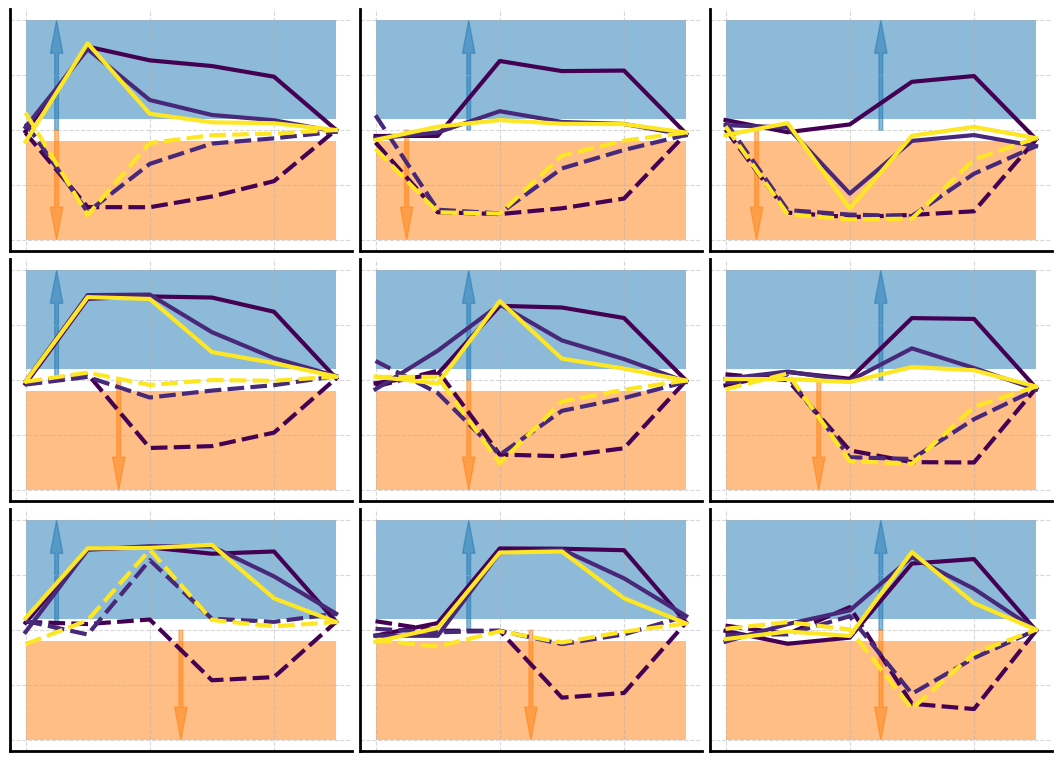

In [64]:
fig, axs = plt.subplots(
    3, 3, figsize=(3 * 3.5, 3 * 2.5), constrained_layout=True, sharex=True, sharey=True
)
set_style()

for u, ax in zip(plot_data["t0_t1"].unique(), axs.T.flatten()):
    t0, t1 = u
    sns.lineplot(
        filter_data(plot_data, {"t0_t1" : u, 'n_conns' : [n_conns[i] for i in [0, -2, -1]]})[0],
        y="local_metric",
        x="step",
        ax=ax,
        style="ag",
        hue="n_conns",
        palette="viridis",
    )
    # ax.vlines(x = [t0 - 0.5 ], ymin = -1, ymax = 1, color = 'blue', alpha = .2)
    # ax.vlines(x = [t1 - 0.5 ], ymin = -1, ymax = 1, color = 'red', alpha = .2)
    c1 = ax.fill_betweenx([0.1, 1], 0, nb_steps, alpha=0.5, label="M0")
    c2 = ax.fill_betweenx([-0.1, -1], 0, nb_steps, alpha=0.5, label="M1")

    ax.arrow(
        t0 - 0.5,
        0,
        0,
        0.7,
        alpha=0.5,
        width=0.06,
        head_width=0.2,
        color=c1.get_facecolor()[0],
    )
    ax.arrow(
        t1 - 0.5,
        0,
        0,
        -0.7,
        alpha=0.5,
        width=0.06,
        head_width=0.2,
        color=c2.get_facecolor()[0],
    )
    ax.legend()
    # ax.set_title(u)

    if t1 == 3:
        ax.set_xlabel("")
    else:
        ax.set_xlabel("")

    if t0 == 1:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("")

    ax.legend().remove()
    ax.grid(visible=True, linestyle="--", alpha=0.5)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)

fig.savefig(f"../results/imgs/random_noisy_timings_new_3.svg")

In [63]:
plot_data.to_csv(f"../results/random_noisy_timings_data")